# Word2Vec training

This notebook is based on the [word2vec-pytorch](https://github.com/OlgaChernytska/word2vec-pytorch/tree/18d4f24c4d82dde76de9f6e4d88bbcbcf68befc2) repo.

In [ ]:
%%bash
wget https://s3.amazonaws.com/research.metamind.io/wikitext/wikitext-2-v1.zip -O ../datasets/wikitext-2-v1.zip
unzip ../datasets/wikitext-2-v1.zip -d ../datasets/

In [ ]:
import torch
import numpy as np
from torch import nn
from torch.utils.data import Dataset, DataLoader


import matplotlib.pyplot as plt
import seaborn as sns

sns.set_style('darkgrid')
plt.rcParams.update({'font.size': 14})

In [ ]:
TRAIN_TOKENS = '../datasets/wikitext-2/wiki.train.tokens'
VALID_TOKENS = '../datasets/wikitext-2/wiki.valid.tokens'

SKIPGRAM_N_WORDS = 4
MIN_WORD_FREQUENCY = 5
MAX_SEQUENCE_LENGTH = 256

EMBED_DIM = 256
EMBED_MAX_NORM = 1
BATCH_SIZE = 16
NUM_EPOCHS = 20

In [ ]:
from torchtext.data.utils import get_tokenizer


tokenizer = get_tokenizer("basic_english", language="en")


def load_and_preprocess_dataset(path):
    with open(path, 'r') as file:
        lines = file.readlines()

    data = list(filter(
        lambda sent: len(sent) > SKIPGRAM_N_WORDS * 2,
        map(tokenizer, lines)
    ))

    return data

In [ ]:
train_data = load_and_preprocess_dataset(TRAIN_TOKENS)
valid_data = load_and_preprocess_dataset(VALID_TOKENS)

total_train_tokens = sum(len(sent) for sent in train_data)
total_valid_tokens = sum(len(sent) for sent in valid_data)

print(f'Num sentences: train - {len(train_data)}, valid - {len(valid_data)})')
print(f'Total tokens: train - {total_train_tokens}, valid - {total_valid_tokens})')
print(f'Average tokens in sentence: {total_train_tokens / len(train_data):.2f}')

In [ ]:
_ = sns.displot([len(sent) for sent in train_data])

In [ ]:
from torchtext.vocab import build_vocab_from_iterator


vocab = build_vocab_from_iterator(train_data, specials=["<unk>"], min_freq=MIN_WORD_FREQUENCY)
vocab.set_default_index(vocab["<unk>"])

VOCAB_SIZE = len(vocab)
print(f'Vocab size: {VOCAB_SIZE}')

In [ ]:
train_data[250]

In [ ]:
vocab(train_data[250])

In [ ]:
vocab(['skibididopdopdopyesyesyes'])

In [ ]:
def collate_fn(batch):
    """
    Collate_fn for Skip-Gram model to be used with Dataloader.
    `batch` is expected to be list of text paragrahs.

    Context is represented as N=SKIPGRAM_N_WORDS past words 
    and N=SKIPGRAM_N_WORDS future words.

    Long paragraphs will be truncated to contain
    no more that MAX_SEQUENCE_LENGTH tokens.

    Each element in `batch_input` is a middle word.
    Each element in `batch_output` is a context word.
    """
    batch_input, batch_output = [], []
    for text in batch:
        text_tokens_ids = vocab(text)

        if MAX_SEQUENCE_LENGTH:
            text_tokens_ids = text_tokens_ids[:MAX_SEQUENCE_LENGTH]

        for idx in range(len(text_tokens_ids) - SKIPGRAM_N_WORDS * 2):
            token_id_sequence = text_tokens_ids[idx : (idx + SKIPGRAM_N_WORDS * 2 + 1)]
            input_ = token_id_sequence.pop(SKIPGRAM_N_WORDS)
            outputs = token_id_sequence

            batch_input += [input_] * len(outputs)
            batch_output += outputs

    batch_input = torch.LongTensor(batch_input)
    batch_output = torch.LongTensor(batch_output)

    return batch_input, batch_output

In [ ]:
train_loader = DataLoader(
    train_data,
    batch_size=BATCH_SIZE,
    num_workers=8,
    pin_memory=True,
    collate_fn=collate_fn,
    shuffle=True
)

valid_loader = DataLoader(
    valid_data,
    batch_size=BATCH_SIZE,
    num_workers=4,
    pin_memory=True,
    collate_fn=collate_fn,
    shuffle=False
)

In [ ]:
next(iter(train_loader))

In [ ]:
import torch.nn as nn
from torch.utils.data import DataLoader
from torch.optim import Optimizer
from tqdm import tqdm


def train(model: nn.Module, data_loader: DataLoader, optimizer: Optimizer, loss_fn, device: torch.device):
    model.train()

    total_loss = 0

    for x, y in tqdm(data_loader):
        x, y = x.to(device), y.to(device)

        optimizer.zero_grad()

        output = model(x)

        loss = loss_fn(output, y)

        loss.backward()

        total_loss += loss.item()
        
        optimizer.step()

    return total_loss / len(data_loader)


In [ ]:
import torch
import torch.nn as nn
from torch.utils.data import DataLoader


@torch.inference_mode()
def evaluate(model: nn.Module, data_loader: DataLoader, loss_fn, device: torch.device):
    model.eval()

    total_loss = 0

    for x, y in tqdm(data_loader):
        x, y = x.to(device), y.to(device)

        output = model(x)

        loss = loss_fn(output, y)

        total_loss += loss.item()

    return total_loss / len(data_loader)


In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns


sns.set(style='darkgrid')


def plot_stats(
    train_loss: list[float],
    valid_loss: list[float],
    title: str
):
    plt.figure(figsize=(16, 8))

    plt.title(title + ' loss')

    plt.plot(train_loss, label='Train loss')
    plt.plot(valid_loss, label='Valid loss')
    plt.legend()

    plt.show()

In [ ]:
from IPython.display import clear_output


def fit(model, train_loader, valid_loader, optimizer, loss_fn, device, num_epochs, title, scheduler=None):
    train_loss_history, valid_loss_history = [], []

    for epoch in range(num_epochs):
        train_loss = train(model, train_loader, optimizer, loss_fn, device)
        valid_loss = evaluate(model, valid_loader, loss_fn, device)

        train_loss_history.append(train_loss)
        valid_loss_history.append(valid_loss)
        
        clear_output()

        plot_stats(
            train_loss_history, valid_loss_history,
            title
        )
        
        if scheduler is not None:
            scheduler.step()

In [ ]:
from torch import nn


class Word2VecModel(nn.Module):
    def __init__(self, embed_dim, embed_max_norm, vocab_size):
        super().__init__()

        self.embeds = nn.Embedding(
            num_embeddings=vocab_size,
            embedding_dim=embed_dim,
            max_norm=embed_max_norm
        )

        self.decoder = nn.Linear(embed_dim, vocab_size)

    def forward(self, x):
        return self.decoder(self.embeds(x))

In [ ]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

print(device)
print(torch.cuda.get_device_name())

loss_fn = nn.CrossEntropyLoss()

In [ ]:
model = Word2VecModel(
    embed_dim=EMBED_DIM,
    embed_max_norm=EMBED_MAX_NORM,
    vocab_size=VOCAB_SIZE
).to(device)

optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, NUM_EPOCHS)

fit(model, train_loader, valid_loader, optimizer, loss_fn, device, NUM_EPOCHS, 'Word2Vec model', scheduler)

In [ ]:
torch.save(model.state_dict(), "word2vec.pt")

In [ ]:
model = Word2VecModel(
    embed_dim=EMBED_DIM,
    embed_max_norm=EMBED_MAX_NORM,
    vocab_size=VOCAB_SIZE
).to(device)

In [ ]:
model.load_state_dict(torch.load("word2vec.pt"))

In [ ]:
import re


def get_similarities(embed_vector):
    similarities = embed_matrix @ embed_vector / embed_norms / torch.norm(embed_vector)
    top_indices = similarities.argsort(descending=True)
    return similarities, top_indices


def get_similar(query, num_similar=5):
    print(f'Processing query \"{query}\"')
    split_query = re.split('([^a-zA-Z0-9])', query)
    index = vocab[split_query[0]]
    embed_vector = torch.clone(embed_matrix[index])
    if index > 0:
        print(f'Found word \"{split_query[0]}\" in vocab')
    else:
        print(f'Word \"{split_query[0]}\" not in vocab, using <unk>')

    for i in range(2, len(split_query), 2):
        index = vocab[split_query[i]]
        if index > 0:
            print(f'Found word \"{split_query[i]}\" in vocab, ', end='')
        else:
            print(f'Word \"{split_query[i]}\" not in vocab, using <unk>, ', end='')
        print(f'operation \"{split_query[i - 1]}\"')

        if split_query[i - 1] == '+':
            embed_vector += embed_matrix[index]
        elif split_query[i - 1] == '-':
            embed_vector -= embed_matrix[index]
        else:
            raise ValueError('Unknown operation')

    similarities, top_indices = get_similarities(embed_vector)

    itos = vocab.get_itos()
    print('Top similar:')
    for top_index in top_indices[:num_similar]:
        print(f'    {itos[top_index]}: sim = {similarities[top_index]:.4f}')

In [ ]:
embed_matrix = model.embeds.weight.detach().cpu()
embed_norms = (embed_matrix ** 2).sum(1).sqrt()

In [ ]:
get_similar('woman')

In [ ]:
get_similar('kick')

In [ ]:
get_similar('help')

In [ ]:
get_similar('bread')

In [ ]:
get_similar('man', num_similar=10)

In [ ]:
v = get_similar('king-man+woman', num_similar=10)

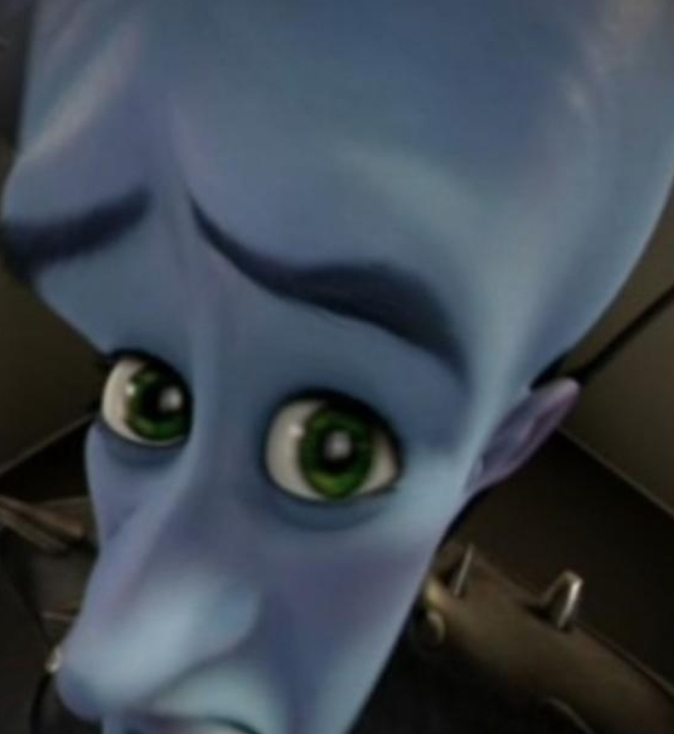

NO QUEEN?

# FastText for sentiment classification

In [ ]:
%%bash
# kaggle datasets download -d shivkumarganesh/bumble-dating-app-google-play-store-review -p ../datasets/
unzip ../datasets/bumble-dating-app-google-play-store-review.zip -d ../datasets/bumble

In [ ]:
import pandas as pd
import fasttext
import fasttext.util

In [ ]:
fasttext.util.download_model('en')
ft = fasttext.load_model('cc.en.300.bin')

In [ ]:
ft.get_word_vector('mother').shape

In [ ]:
ft.get_nearest_neighbors('dog')

In [ ]:
data = pd.read_csv('../datasets/bumble/bumble_google_play_reviews.csv')
data = data[data.content.notna()]
data

In [ ]:
X = data.content.apply(tokenizer).to_list()
y = (data.score >= 4).to_numpy().astype(int)
_ = sns.displot(y)

In [ ]:
plt.hist([len(sent) for sent in X], bins=100)
plt.yscale('log')
plt.ylabel('count')
plt.xlabel('num words')
plt.show()

In [ ]:
from sklearn.model_selection import train_test_split

X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.25, random_state=42)
len(X_train), len(X_valid)

In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score

In [ ]:
X_train_sents = [' '.join(sent) for sent in X_train]
X_valid_sents = [' '.join(sent) for sent in X_valid]

In [ ]:
tf_idf = TfidfVectorizer(min_df=5).fit(X_train_sents)
tf_idf_train = tf_idf.transform(X_train_sents)
tf_idf_valid = tf_idf.transform(X_valid_sents)

tf_idf_train.shape, tf_idf_valid.shape

In [ ]:
lr = LogisticRegression(max_iter=1000).fit(tf_idf_train, y_train)

In [ ]:
print(f'Tf-idf + LogRegr train acc: {accuracy_score(lr.predict(tf_idf_train), y_train):.4f}')
print(f'Tf-idf + LogRegr valid acc: {accuracy_score(lr.predict(tf_idf_valid), y_valid):.4f}')

In [ ]:
def get_sentence_embedding(sent):
    embeds = []
    for word in sent:
        embeds += [ft.get_word_vector(word)]

    return np.stack(embeds, axis=0).mean(0)

In [ ]:
train_embeds = np.stack([get_sentence_embedding(sent) for sent in X_train], axis=0)
valid_embeds = np.stack([get_sentence_embedding(sent) for sent in X_valid], axis=0)

In [ ]:
lr = LogisticRegression(max_iter=1000).fit(train_embeds, y_train)

In [ ]:
print(f'FastText + LogRegr train acc: {accuracy_score(lr.predict(train_embeds), y_train):.4f}')
print(f'FastText + LogRegr valid acc: {accuracy_score(lr.predict(valid_embeds), y_valid):.4f}')

In [ ]:
BATCH_SIZE = 128
MAX_SEQUENCE_LENGTH = 256
MODEL_BLOCKS = 2
MODEL_CHANNELS = 300
NUM_EPOCHS = 5

In [ ]:
class EmbeddingsDataset(Dataset):
    def __init__(self, sents, targets, max_length):
        super().__init__()

        self.max_length = max_length
        self.sents = sents
        self.targets = targets

    def __len__(self):
        return len(self.sents)

    def __getitem__(self, item):
        sent = self.sents[item]

        length = min(len(sent), self.max_length)

        embeds = []

        for word in sent[:length]:
            embeds += [torch.from_numpy(ft.get_word_vector(word).astype(np.float32))]

        embeds = torch.stack(embeds, dim=1)
        
        padding = torch.zeros((embeds.shape[0], self.max_length - length))
        
        embeds = torch.cat([embeds, padding], dim=1)

        return embeds, length, self.targets[item]

In [ ]:
train_set = EmbeddingsDataset(X_train, y_train, max_length=MAX_SEQUENCE_LENGTH)
valid_set = EmbeddingsDataset(X_valid, y_valid, max_length=MAX_SEQUENCE_LENGTH)

train_loader = DataLoader(train_set, batch_size=BATCH_SIZE, num_workers=8,
                          pin_memory=True, shuffle=True)
valid_loader = DataLoader(valid_set, batch_size=BATCH_SIZE, num_workers=8,
                         pin_memory=True, shuffle=False)

In [ ]:
class BasicBlock(nn.Module):
    def __init__(self, num_channels, kernel_size):
        super().__init__()
        padding = (kernel_size - 1) // 2

        self.conv1 = nn.Conv1d(
            num_channels,
            num_channels,
            kernel_size,
            padding=padding,
            bias=False
        )
        self.bn1 = nn.BatchNorm1d(num_channels)

        self.conv2 = nn.Conv1d(
            num_channels,
            num_channels,
            kernel_size,
            padding=padding,
            bias=False
        )
        self.bn2 = nn.BatchNorm1d(num_channels)
        self.relu = nn.LeakyReLU(0.1)

    def forward(self, x):
        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)
        out = self.conv2(out)
        out = self.bn2(out)
        out = self.relu(out + x)
        return out

class TextCNN(nn.Module):
    def __init__(self, num_blocks, num_channels, num_classes, kernel_size=5):
        super().__init__()

        self.backbone = nn.Sequential(
            *[BasicBlock(num_channels, kernel_size) for _ in range(num_blocks)]
        )

        self.classifier = nn.Linear(num_channels, num_classes)

    @staticmethod
    def get_lengths_mask(embeds, lengths):
        mask = torch.arange(embeds.shape[-1]).unsqueeze(0).to(embeds.device)
        mask = (mask < lengths.unsqueeze(1)).to(torch.float)
        return mask.unsqueeze(1)

    def forward(self, embeds, lengths):
        # embeds: (B, C, T), lengths: (B, )
        features = self.backbone(embeds)
        # features: (B, C, T)
        mask = self.get_lengths_mask(embeds, lengths)
        # mask: (B, 1, T)
        features = (features * mask).sum(-1) / lengths.unsqueeze(1)
        # features: (B, C)
        logits = self.classifier(features)
        # logits: (B, num_classes)
        return logits

In [ ]:
def train(model: nn.Module, data_loader: DataLoader, optimizer: Optimizer, loss_fn, device: torch.device):
    model.train()

    total_loss = 0
    total_correct = 0

    for embeds, lengths, labels in tqdm(data_loader):
        embeds = embeds[..., :lengths.max()]

        embeds, lengths, labels = embeds.to(device), lengths.to(device), labels.to(device)

        optimizer.zero_grad()

        output = model(embeds, lengths)

        loss = loss_fn(output, labels)

        loss.backward()

        total_loss += loss.item()
        total_correct += (output.argmax(1) == labels).sum().item()

        optimizer.step()

    return total_loss / len(data_loader), total_correct / len(data_loader.dataset)


In [ ]:
@torch.inference_mode()
def evaluate(model: nn.Module, data_loader: DataLoader, loss_fn, device: torch.device):
    model.eval()

    total_loss = 0
    total_correct = 0

    for embeds, lengths, labels in tqdm(data_loader):
        embeds = embeds[..., :lengths.max()]
        
        embeds, lengths, labels = embeds.to(device), lengths.to(device), labels.to(device)

        output = model(embeds, lengths)

        loss = loss_fn(output, labels)

        total_loss += loss.item()

        total_correct += (output.argmax(dim=1) == labels).sum().item()

    return total_loss / len(data_loader), total_correct / len(data_loader.dataset)


In [ ]:
def plot_stats(
    train_loss: list[float],
    valid_loss: list[float],
    train_accuracy: list[float],
    valid_accuracy: list[float],
    title: str
):
    plt.figure(figsize=(16, 8))

    plt.title(title + ' loss')

    plt.plot(train_loss, label='Train loss')
    plt.plot(valid_loss, label='Valid loss')
    plt.legend()

    plt.show()
    
    plt.figure(figsize=(16, 8))

    plt.title(title + ' accuracy')

    plt.plot(train_accuracy, label='Train accuracy')
    plt.plot(valid_accuracy, label='Valid accuracy')
    plt.legend()

    plt.show()

In [ ]:
from IPython.display import clear_output


def fit(model, train_loader, valid_loader, optimizer, loss_fn, device, num_epochs, title, scheduler=None):
    train_loss_history, valid_loss_history = [], []
    train_accuracy_history, valid_accuracy_history = [], []

    for epoch in range(num_epochs):
        train_loss, train_accuracy = train(model, train_loader, optimizer, loss_fn, device)
        valid_loss, valid_accuracy = evaluate(model, valid_loader, loss_fn, device)

        train_loss_history.append(train_loss)
        valid_loss_history.append(valid_loss)
        
        train_accuracy_history.append(train_accuracy)
        valid_accuracy_history.append(valid_accuracy)

        clear_output()

        plot_stats(
            train_loss_history, valid_loss_history,
            train_accuracy_history, valid_accuracy_history,
            title
        )
        
        if scheduler is not None:
            scheduler.step()

In [ ]:
model = TextCNN(num_blocks=MODEL_BLOCKS, num_channels=MODEL_CHANNELS, num_classes=2).to(device)

optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, NUM_EPOCHS)

criterion = nn.CrossEntropyLoss()

In [ ]:
fit(model, train_loader, valid_loader, optimizer, loss_fn, device, NUM_EPOCHS, 'TextCNN', scheduler)